In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import datasets, transforms
import torchvision.utils as vutils
import matplotlib.pyplot as plt
import numpy as np
import random

In [2]:
# make dataloader
def create_dataloader(dataset_name, transform, valid=False):
    test_dl, valid_dl = None, None

    if dataset_name == 'MNIST':
        train_datasets = datasets.MNIST(root='../datasets', train=True, download=True, transform=transform)
        if valid:
            n_samples = len(train_datasets)
            train_size = int(n_samples * 0.8)
            subset1_indices = list(range(0,train_size))
            subset2_indices = list(range(train_size,n_samples))

            train_dataset = Subset(train_datasets, subset1_indices)
            valid_dataset = Subset(train_datasets, subset2_indices)

            train_dl = DataLoader(train_dataset, batch_size=TRAIN_BATCH_SIZE, shuffle=True)
            valid_dl = DataLoader(valid_dataset, batch_size=VALID_BATCH_SIZE, shuffle=False)
        else:
            train_dl = DataLoader(train_datasets,   batch_size=TRAIN_BATCH_SIZE, shuffle=True)

        test_dataset = datasets.MNIST(root='../datasets', train=False, download=True, transform=transform)
        test_dl = DataLoader(test_dataset, batch_size=TEST_BATCH_SIZE, shuffle=False)
    
    return train_dl, test_dl, valid_dl



In [3]:
class Generator(nn.Module):
    def __init__(self, nz, ngf):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(nz, ngf*4, 3, 1, 0, bias=False),
            nn.BatchNorm2d(ngf*4),
            nn.ReLU(True),
            #ngf*3*3
            nn.ConvTranspose2d(ngf*4, ngf*2, 3, 2, 0, bias=False),
            nn.BatchNorm2d(ngf*2),
            nn.ReLU(True),
            #ngf*2*7*7
            nn.ConvTranspose2d(ngf*2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            #ngf*14*14
            nn.ConvTranspose2d(ngf, 1, 4, 2, 1, bias=False),
            nn.Tanh()
            #1*28*28
        )
    def forward(self, x):
        return self.main(x)

class Discriminator(nn.Module):
    def __init__(self, ndf):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            #1*28*28
            nn.Conv2d(1, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            #ngf*14*14
            nn.Conv2d(ndf, ndf*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf*2),
            nn.LeakyReLU(0.2, inplace=True),
            #ngf*2*7*7
            nn.Conv2d(ndf*2, ndf*4, 3, 2, 0, bias=False),
            nn.BatchNorm2d(ndf*4),
            nn.LeakyReLU(0.2, inplace=True),
            #ngf*2*7*7
            nn.Conv2d(ndf*4, 1, 3, 1, 0, bias=False),
            #3*28*28
            
        )
    def forward(self, x):
        return self.main(x).squeeze()


In [4]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('Linear') != -1:        # 全結合層の場合
        m.weight.data.normal_(0.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

EPOCH:0, iter:100, loss_D=-0.305, loss_G=0.197, D(x)=0.219, D(G(z))=-0.0859/-0.197
EPOCH:0, iter:200, loss_D=-0.403, loss_G=0.296, D(x)=0.287, D(G(z))=-0.116/-0.296
EPOCH:1, iter:100, loss_D=-0.396, loss_G=0.128, D(x)=0.125, D(G(z))=-0.272/-0.128
EPOCH:1, iter:200, loss_D=-0.379, loss_G=0.105, D(x)=0.104, D(G(z))=-0.274/-0.105
EPOCH:2, iter:100, loss_D=-0.378, loss_G=0.166, D(x)=0.151, D(G(z))=-0.226/-0.166
EPOCH:2, iter:200, loss_D=-0.33, loss_G=0.284, D(x)=0.271, D(G(z))=-0.059/-0.284
EPOCH:3, iter:100, loss_D=-0.369, loss_G=0.111, D(x)=0.109, D(G(z))=-0.26/-0.111
EPOCH:3, iter:200, loss_D=-0.357, loss_G=0.108, D(x)=0.109, D(G(z))=-0.248/-0.108
EPOCH:4, iter:100, loss_D=-0.347, loss_G=0.139, D(x)=0.124, D(G(z))=-0.223/-0.139
EPOCH:4, iter:200, loss_D=-0.31, loss_G=0.219, D(x)=0.217, D(G(z))=-0.0933/-0.219
EPOCH:5, iter:100, loss_D=-0.322, loss_G=0.104, D(x)=0.0918, D(G(z))=-0.23/-0.104
EPOCH:5, iter:200, loss_D=-0.299, loss_G=0.101, D(x)=0.0876, D(G(z))=-0.211/-0.101
EPOCH:6, iter:10

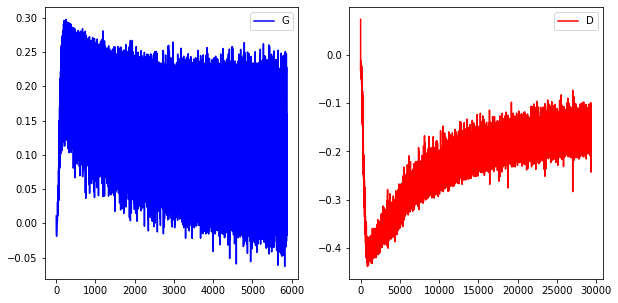

In [6]:
#WGAN

# Constants
EPOCH_NUM = 25
TRAIN_BATCH_SIZE = 256
TEST_BATCH_SIZE = 8
N_CRITIC = 5
device = f"cuda:{0}" if torch.cuda.is_available() else "cpu"

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5),(0.5))])

train_dl, test_dl, _ = create_dataloader('MNIST', transform, valid=False)

nz = 100
ngf = 128
ndf = 128
netG = Generator(nz,ngf).to(device)
netG.apply(weights_init)
netD = Discriminator(ndf).to(device)
netD.apply(weights_init)

fixed_noise = torch.randn(8, nz, 1, 1, device=device)

optim_D = optim.RMSprop(netD.parameters(), lr=0.00005)
optim_G = optim.RMSprop(netG.parameters(), lr=0.00005)

G_loss_list, D_loss_list = [], []
best_loss_G, best_loss_D = None,None

testdata, _ = next(iter(test_dl))
testdata = testdata[0].to(device)

for epoch in range(EPOCH_NUM):
    D_x, D_G_z1, D_G_z2 = 0, 0, 0
    iter_num = 0

    for datas, _ in train_dl:
        iter_num += 1
        real_img = datas.to(device)
        img_num = real_img.size(0)

        noise = torch.randn(img_num, nz, 1, 1, device=device)

        real_target = torch.full((img_num,), 1., device=device)
        fake_target = torch.full((img_num,), 0., device=device)
        #########################################
        for n in range(N_CRITIC):
            netD.zero_grad()

            logits_real = netD(real_img).view(-1)
            loss_real = torch.mean(logits_real)
            D_x = logits_real.mean().item()

            fake_img = netG(noise)
            logits_fake = netD(fake_img.detach()).view(-1)
            loss_fake = torch.mean(logits_fake)
            D_G_z1 = logits_fake.mean().item()            

            loss_D = - loss_real + loss_fake
            D_loss_list.append(loss_D.item())

            loss_D.backward()
            optim_D.step()

        ####################################
            for p in netD.parameters():
                p.data.clamp_(-0.01,0.01)
        
        ####################################
        netG.zero_grad()

        logits_fake_G = netD(fake_img)
        loss_G = - torch.mean(logits_fake_G)
        D_G_z2 = logits_fake_G.mean().item()
        G_loss_list.append(loss_G.item())

        loss_G.backward()
        optim_G.step()
        
        ####################################
        if iter_num%100 == 0:
            print('EPOCH:{:}, iter:{:}, loss_D={:.3}, loss_G={:.3}, D(x)={:.3}, D(G(z))={:.3}/{:.3}'.format(epoch, iter_num, loss_D, loss_G, D_x, D_G_z1, D_G_z2))
        if epoch==0 or best_loss_D >= loss_D:
            best_loss_D = loss_D
        if epoch==0 or best_loss_G >= loss_G:
            best_loss_G = loss_G

print('Best loss_D={:.3} Best loss_G={:.3}'.format(best_loss_D, best_loss_G))

fig = plt.figure(figsize=(10.0, 5.0))
ax1 = fig.add_subplot(1,2,1)
ax1.plot(G_loss_list, 'b', label='G')
ax1.legend()
ax2 = fig.add_subplot(1,2,2)
ax2.plot(D_loss_list, 'r', label='D')
ax2.legend()
plt.show()

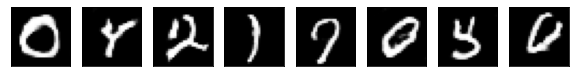

In [7]:
fixed_noise = torch.randn(8*8, nz, 1, 1, device=device)
img = netG(fixed_noise)

fig = plt.figure(figsize=(10.0, 5.0))
for i, img in enumerate(img.squeeze().cpu().detach().numpy()):
    ax = fig.add_subplot(i%8,8,i+1,xticks=[], yticks=[])
    ax.imshow(img,cmap='binary_r')

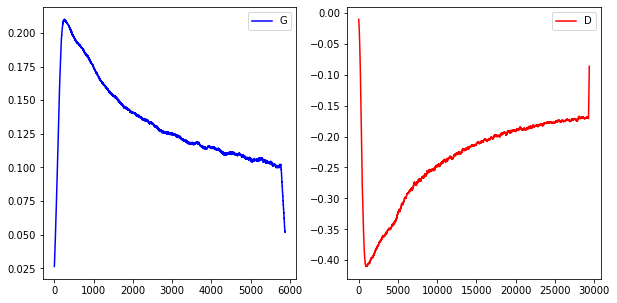

In [8]:
num = 200
b = np.ones(num)/num

G_loss_list_ave = np.convolve(G_loss_list, b, mode='same')
D_loss_list_ave = np.convolve(D_loss_list, b, mode='same')

fig = plt.figure(figsize=(10.0, 5.0))
ax1 = fig.add_subplot(1,2,1)
ax1.plot(G_loss_list_ave, 'b', label='G')
ax1.legend()
ax2 = fig.add_subplot(1,2,2)
ax2.plot(D_loss_list_ave, 'r', label='D')
ax2.legend()
plt.show()